In [31]:
import pandas as pd
import numpy as np
from numba.experimental.jitclass.base import imp_dtor
from sklearn.model_selection import train_test_split

# read the kick dataset
df = pd.read_csv('data/20250831_cleaned_kick_TIODE.csv')
# show all columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41436 entries, 0 to 41435
Columns: 124 entries, PurchaseTimestamp to VNST_WV
dtypes: bool(106), float64(12), int64(6)
memory usage: 9.9 MB


In [33]:
# Separate features and target
X = df.drop('IsBadBuy', axis=1)
Y = df['IsBadBuy']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(categorical_cols)
print(numerical_cols)

[]
['PurchaseTimestamp', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale', 'PurchaseYear', 'PurchaseMonth']


In [34]:
# Create a 30% train/test split from our samples.
# We set the random_state to the constant 10 to ensure it is the same from run-to-run.
# We set the stratisfy parameter to the labels, that way we get an even selection of 0 and 1 values in our testing set.
# Otherwise, we may end up with unbalanced 0/1 labels across the two splits.
# We use X.values to get arrays for the features, instead of a DataFrame with column names etc.
random_state = 10
test_set_size = 0.3 # 30%
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values,test_size=test_set_size, stratify=Y, random_state=random_state)
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 29005
Size of testing set: 12431


In [35]:
from sklearn.preprocessing import StandardScaler
random_seed = 10
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
model = MLPClassifier(max_iter=700, random_state=random_state)
model.fit(X_train, y_train)

MLPClassifier(max_iter=700, random_state=10)

In [38]:
# Print model performance for the first model training
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.9661782451301499
Test accuracy: 0.8071756093636876
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     10821
           1       0.23      0.21      0.22      1610

    accuracy                           0.81     12431
   macro avg       0.56      0.55      0.56     12431
weighted avg       0.80      0.81      0.80     12431



In [40]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
# hide warnings from optimizer not converging
import warnings
warnings.filterwarnings('ignore')
# hide warnings in subprocesses, required because we use multiple n_jobs
import os
os.environ["PYTHONWARNINGS"] = "ignore"
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)]}
cv_1 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), return_train_score=True, cv=10,
n_jobs=-1)
cv_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (25,), (45,), (65,),
                                                (85,)]},
             return_train_score=True)

In [41]:
# GridsearchCV model result
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 5.49146531, 11.19447083, 24.74037466, 28.3130255 , 24.71671979]), 'std_fit_time': array([0.83935317, 0.44710895, 6.093563  , 5.44122215, 3.27395895]), 'mean_score_time': array([0.00485904, 0.00597026, 0.02555296, 0.01847661, 0.00842516]), 'std_score_time': array([0.00171463, 0.00468299, 0.0187936 , 0.01110118, 0.00668734]), 'param_hidden_layer_sizes': masked_array(data=[(5,), (25,), (45,), (65,), (85,)],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (5,)}, {'hidden_layer_sizes': (25,)}, {'hidden_layer_sizes': (45,)}, {'hidden_layer_sizes': (65,)}, {'hidden_layer_sizes': (85,)}], 'split0_test_score': array([0.8734919 , 0.85487763, 0.84005515, 0.82281972, 0.82385384]), 'split1_test_score': array([0.86797656, 0.85349879, 0.83626336, 0.82523268, 0.81971734]), 'split2_test_score': array([0.86728714, 0.84867287, 0.84039986, 0.82833506, 0.81730438]), 'split3_test_score': arra

Total number of models:  5


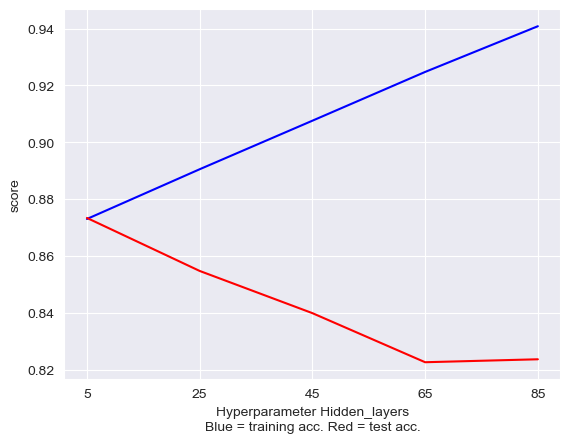

In [42]:
import matplotlib.pyplot as plt
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),
test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(5, 86, 20))
plt.ylabel('score')
plt.show()

Total number of models:  5


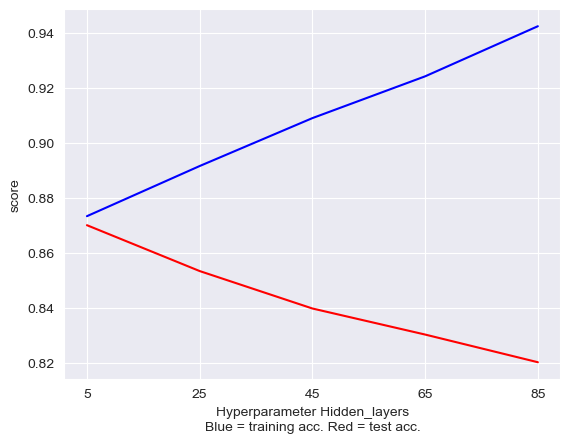

In [43]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),
test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(5, 86, 20))
plt.ylabel('score')
plt.show()

In [44]:
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))
y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_1.best_params_)

Train accuracy: 0.8732287536631615
Test accuracy: 0.8691175287587483
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     10821
           1       0.43      0.03      0.06      1610

    accuracy                           0.87     12431
   macro avg       0.65      0.51      0.49     12431
weighted avg       0.82      0.87      0.82     12431

{'hidden_layer_sizes': (5,)}


In [49]:
# CV2 tune hidde layer = 5
# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}
cv_2 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_2.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]})

In [46]:
print("Train accuracy:", cv_2.score(X_train, y_train))
print("Test accuracy:", cv_2.score(X_test, y_test))
y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_2.best_params_)

Train accuracy: 0.8705050853301155
Test accuracy: 0.8704850776285094
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.00      0.00      0.00      1610

    accuracy                           0.87     12431
   macro avg       0.44      0.50      0.47     12431
weighted avg       0.76      0.87      0.81     12431

{'hidden_layer_sizes': (3,)}


In [47]:
# CV3 tune alpha
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01, 0.001, 0.0001,
0.00001]}
cv_3 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_3.fit(X_train, y_train)
print("Train accuracy:", cv_3.score(X_train, y_train))
print("Test accuracy:", cv_3.score(X_test, y_test))
y_pred = cv_3.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_3.best_params_)

Train accuracy: 0.8705050853301155
Test accuracy: 0.8704850776285094
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.00      0.00      0.00      1610

    accuracy                           0.87     12431
   macro avg       0.44      0.50      0.47     12431
weighted avg       0.76      0.87      0.81     12431

{'alpha': 0.01, 'hidden_layer_sizes': (3,)}


In [50]:
# Recursive Feature Elimination using Logistic Regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
rfe = RFECV(estimator = LogisticRegression(random_state=random_state), cv=10)
rfe.fit(X_train, y_train)
print(rfe.n_features_)

44


In [55]:
# RFE_CV Result
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001,
0.00001]}
rfe_cv = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train)
print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test))
y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))
print(rfe_cv.best_params_)

Train accuracy: 0.8712290984313049
Test accuracy: 0.8708872978843215
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.55      0.02      0.03      1610

    accuracy                           0.87     12431
   macro avg       0.71      0.51      0.48     12431
weighted avg       0.83      0.87      0.81     12431

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


In [63]:
# Feature Selecting using decision tree
import pickle
from sklearn.feature_selection import SelectFromModel
with open('DT.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)
selectmodel = SelectFromModel(dt_best, prefit=True)

# Fit the SelectFromModel instance to your training data
# This step is crucial and was missing in your original code
selectmodel.fit(X_train, y_train)

X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)
print(X_train_sel_model.shape)

ValueError: X has 123 features, but SelectFromModel is expecting 114 features as input.

In [56]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}
cv_sel_model = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))
y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv_sel_model.best_params_)


NameError: name 'X_train_sel_model' is not defined

In [54]:
# Comparing the models to find the best performing model
# A total of six models has been built:
# 1. Default neural network ( model )
# 2. Neural network + grid search ( cv_1 )
# 3. Neural network + grid search ( cv_2 )
# 4. Neural network + grid search ( cv_3 )
# 5. Neural network + feature selection + grid search ( rfe_cv )
# 6. Neural network + feature selection using DT + grid search ( cv_sel_model )

from sklearn.metrics import roc_auc_score
y_pred_proba_nn = model.predict_proba(X_test)
y_pred_proba_cv_1 = cv_1.predict_proba(X_test)
y_pred_proba_cv_2 = cv_2.predict_proba(X_test)
y_pred_proba_cv_3 = cv_3.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_rfe)
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_cv_1 = roc_auc_score(y_test, y_pred_proba_cv_1[:, 1])
roc_index_cv_2 = roc_auc_score(y_test, y_pred_proba_cv_2[:, 1])
roc_index_cv_3 = roc_auc_score(y_test, y_pred_proba_cv_3[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])
print("ROC index on test for NN_default:", roc_index_nn)
print("ROC index on test for NN with gridsearch 1:", roc_index_cv_1)
print("ROC index on test for NN with gridsearch 2:", roc_index_cv_2)
print("ROC index on test for NN with gridsearch 3:", roc_index_cv_3)
print("ROC index on test for NN with feature selection and gridsearch:",
roc_index_rfe_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)



In [ ]:
from sklearn.metrics import roc_curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_cv_1, tpr_cv_1, thresholds_cv_1 = roc_curve(y_test, y_pred_proba_cv_1[:,1])
fpr_cv_2, tpr_cv_2, thresholds_cv_2 = roc_curve(y_test, y_pred_proba_cv_2[:,1])
fpr_cv_3, tpr_cv_3, thresholds_cv_3 = roc_curve(y_test, y_pred_proba_cv_3[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test,
y_pred_proba_cv_sel_model[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr_nn, tpr_nn, label='NN_default {:.3f}'.format(roc_index_nn), color='red',
lw=0.5)
plt.plot(fpr_cv_1, tpr_cv_1, label='NN cv_1 {:.3f}'.format(roc_index_cv_1), color='blue',
lw=0.5)
plt.plot(fpr_cv_2, tpr_cv_2, label='NN cv_2 {:.3f}'.format(roc_index_cv_2),
color='yellow', lw=0.5)
plt.plot(fpr_cv_3, tpr_cv_3, label='NN cv_3 {:.3f}'.format(roc_index_cv_3), color='cyan',
lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='NN rfe_cv {:.3f}'.format(roc_index_rfe_cv),
color='gray', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='black', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle
with open('DT.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)
with open('LR.pickle', 'rb') as f:
    lr_best, roc_index_lr_cv, fpr_lr_cv, tpr_lr_cv = pickle.load(f)
print("ROC index on test for decision tree:", roc_index_dt_cv)
print("ROC index on test for linear regression:", roc_index_lr_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='DT {:.3f}'.format(roc_index_dt_cv), color='red',
lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='LR {:.3f}'.format(roc_index_lr_cv), color='green',
lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='blue', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
def debug_dataframe(df):
    print("=== DataFrame Debugging ===")
    print(f"Shape: {df.shape}")
    print("\n=== Data Types ===")
    print(df.dtypes)

    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\n=== Infinite Values ===")
    for col in df.select_dtypes(include=[np.number]).columns:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            print(f"{col}: {inf_count} infinite values")

    print("\n=== Non-Numeric in Numeric Columns ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        non_numeric = df[col].apply(lambda x: isinstance(x, str)).sum()
        if non_numeric > 0:
            print(f"{col}: {non_numeric} non-numeric values")

    print("\n=== Categorical Columns ===")
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(categorical_cols)

    print("\n=== Sample Data ===")
    print(df.head())

# Run the debugging function
debug_dataframe(X)

=== DataFrame Debugging ===
Shape: (41436, 25)

=== Data Types ===
PurchaseTimestamp                      int64
Auction                               object
VehYear                              float64
Make                                  object
Color                                 object
Transmission                          object
WheelType                             object
VehOdo                               float64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
MMRCurrentRetailRatio                float64
VNST                             